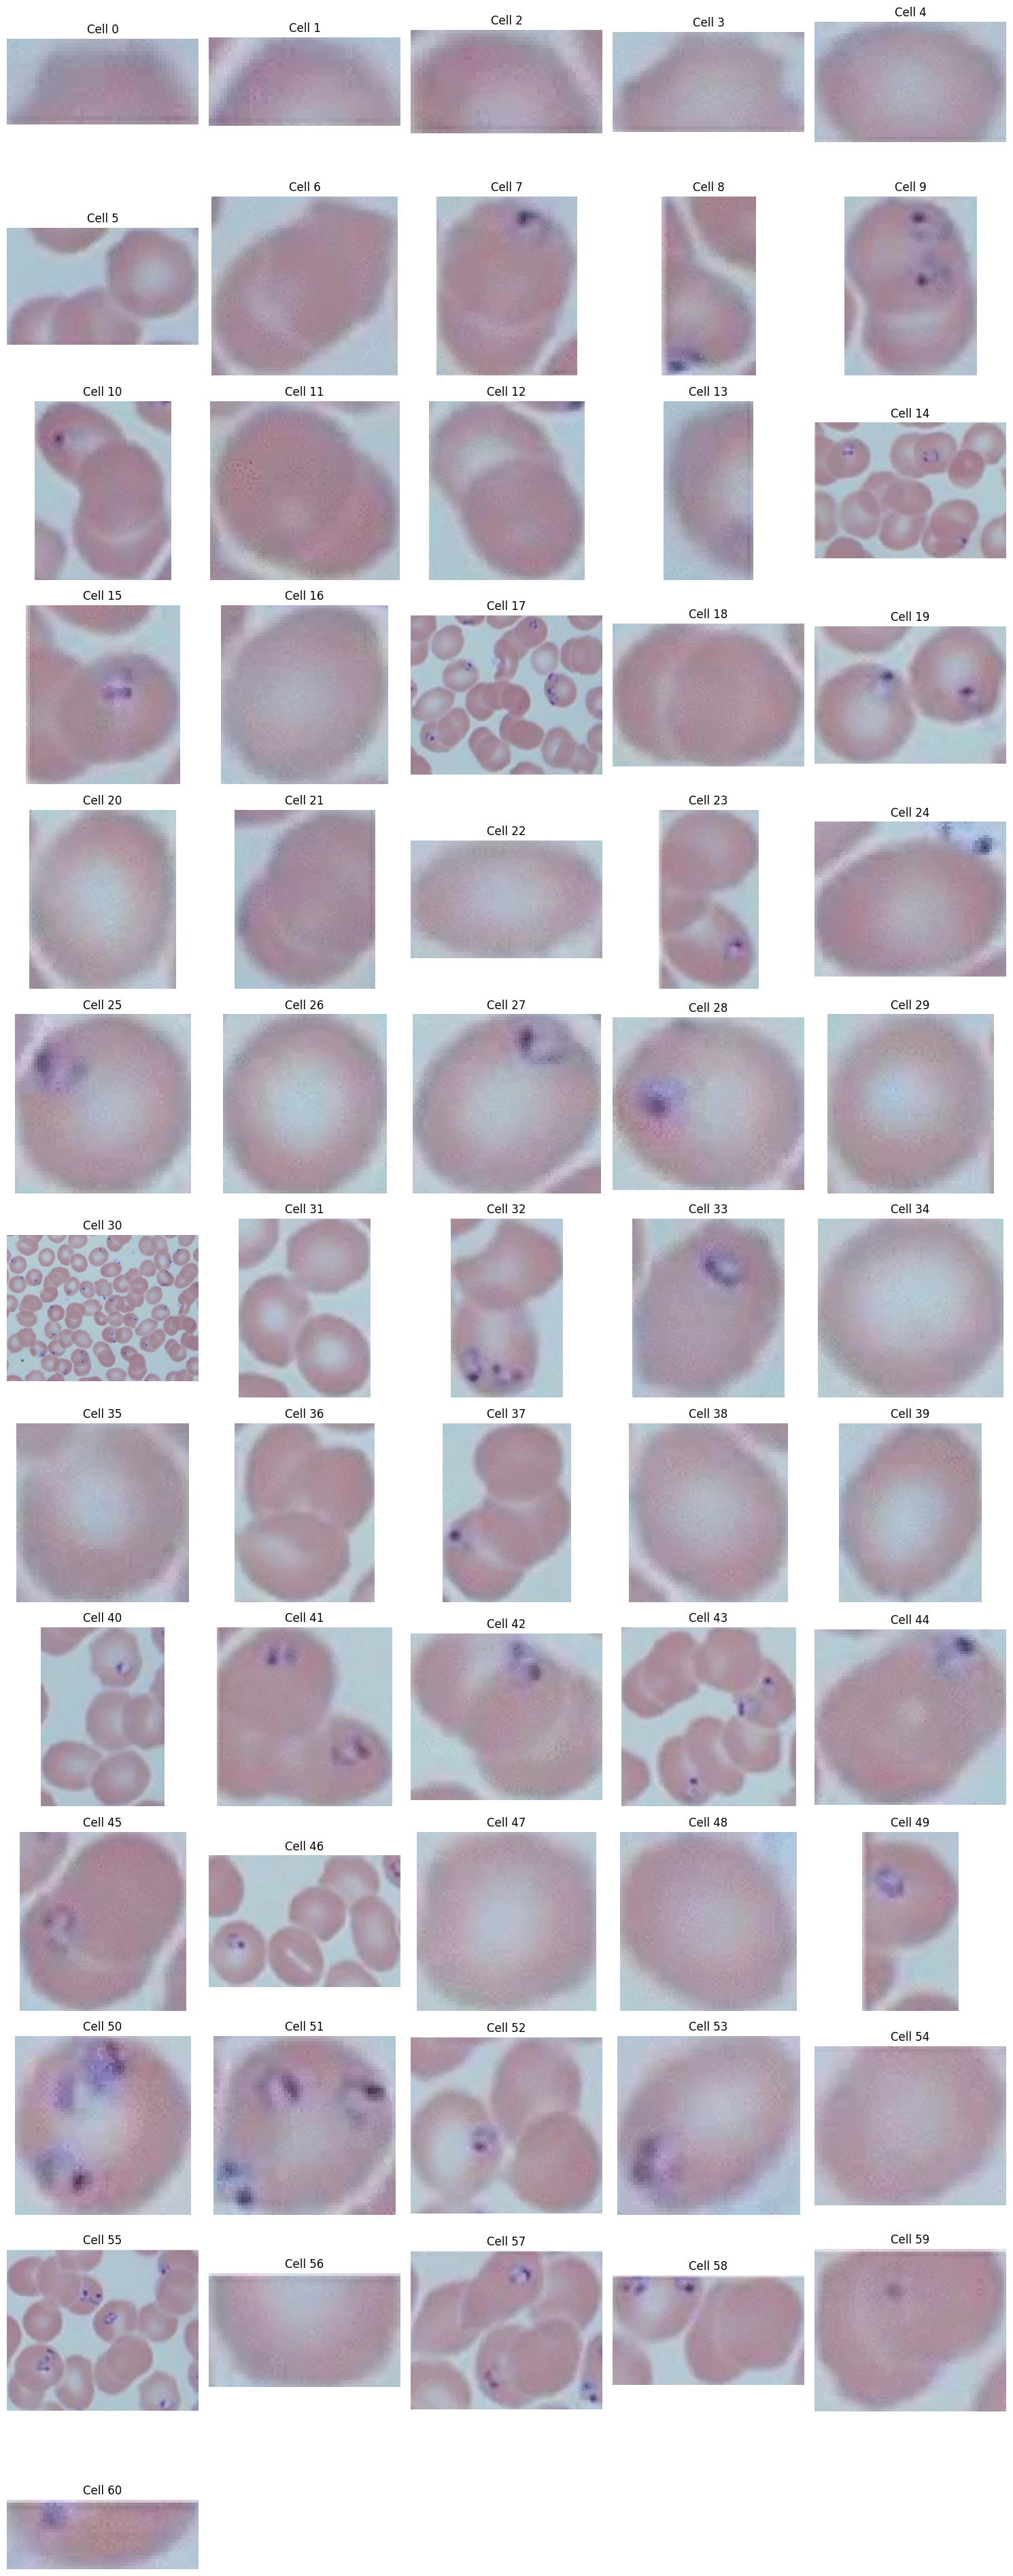

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the multi-celled image
image_path =  "/Users/rajesh/Desktop/testing_multicell/multi.jpg"
image = cv2.imread(image_path)

# Convert to grayscale and blur
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Thresholding
_, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Morphological operations
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
morphed = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

# Find contours
contours, _ = cv2.findContours(morphed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Prepare for display
cropped_cells = []
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    if w > 20 and h > 20:  # Skip tiny noise
        cell = image[y:y+h, x:x+w]
        cell_rgb = cv2.cvtColor(cell, cv2.COLOR_BGR2RGB)
        cropped_cells.append(cell_rgb)

# Display cropped cells
cols = 5
rows = (len(cropped_cells) + cols - 1) // cols
plt.figure(figsize=(15, 3 * rows))
for idx, cell in enumerate(cropped_cells):
    plt.subplot(rows, cols, idx + 1)
    plt.imshow(cell)
    plt.axis('off')
    plt.title(f'Cell {idx}')
plt.tight_layout()
plt.show()


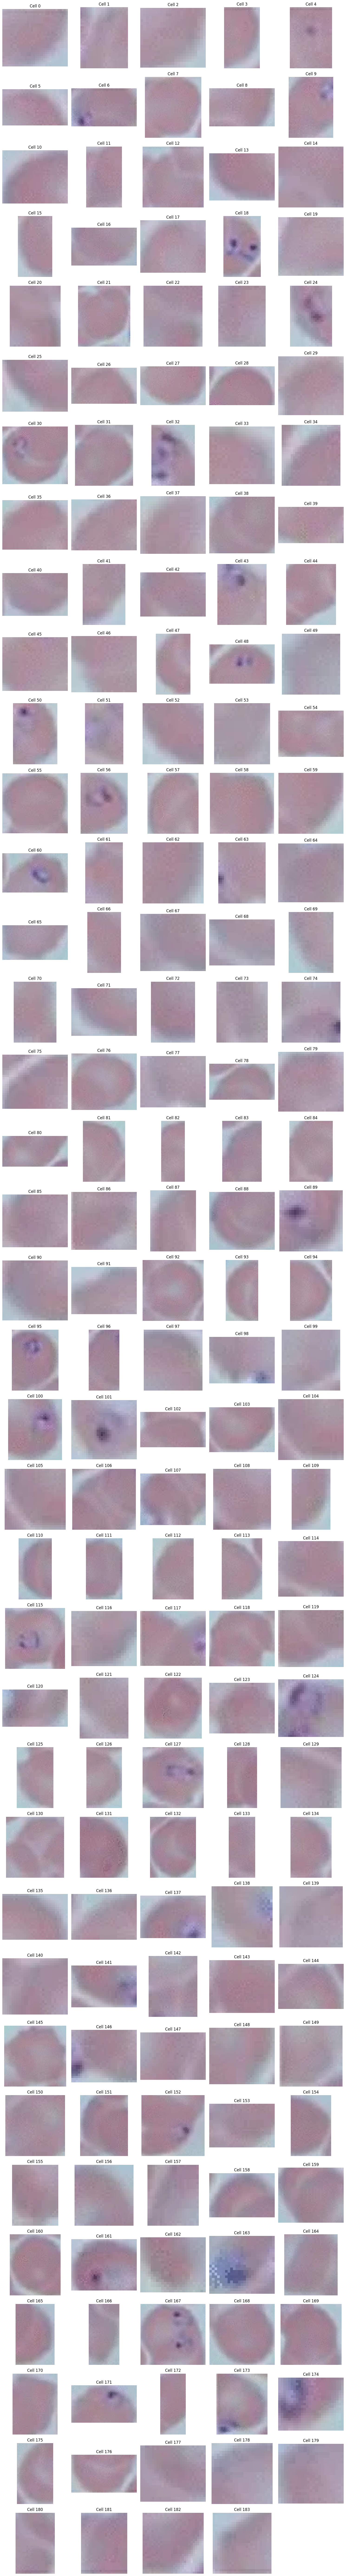

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure, morphology
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max

# Load image
image_path = "/Users/rajesh/Desktop/testing_multicell/multi.jpg"
image = cv2.imread(image_path)

# Ensure image loaded correctly
if image is None:
    raise FileNotFoundError(f"Could not load image at {image_path}")

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply threshold
_, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Remove small noise
cleaned = morphology.remove_small_objects(binary > 0, min_size=30)

# Distance transform
distance = ndi.distance_transform_edt(cleaned)

# Find local maxima (updated approach)
coords = peak_local_max(distance, labels=cleaned, footprint=np.ones((3, 3)))
local_max = np.zeros_like(distance, dtype=bool)
local_max[tuple(coords.T)] = True

# Marker labeling
markers, _ = ndi.label(local_max)

# Apply watershed
labels = watershed(-distance, markers, mask=cleaned)

# Crop and display individual cells
props = measure.regionprops(labels)
cropped_cells = []

for prop in props:
    y1, x1, y2, x2 = *prop.bbox[0:2], *prop.bbox[2:4]
    if (x2 - x1 > 20 and y2 - y1 > 20):  # avoid tiny crops
        cell = image[y1:y2, x1:x2]
        cell_rgb = cv2.cvtColor(cell, cv2.COLOR_BGR2RGB)
        cropped_cells.append(cell_rgb)

# Display individual cells
cols = 5
rows = (len(cropped_cells) + cols - 1) // cols
plt.figure(figsize=(15, 3 * rows))
for idx, cell in enumerate(cropped_cells):
    plt.subplot(rows, cols, idx + 1)
    plt.imshow(cell)
    plt.axis('off')
    plt.title(f'Cell {idx}')
plt.tight_layout()
plt.show()

